In [ ]:
from google.colab import files
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time

import cv2
print(cv2.__version__)
# example of face detection with opencv cascade classifier
from cv2 import imread
from cv2 import rectangle
from cv2 import imshow
from PIL import Image 
import os

# some imports for data augmentation
import matplotlib.image as mpimg
import random
from skimage import exposure
from skimage.util import random_noise
from skimage import transform
from cv2 import resize
#import tensorflow as tf

import pandas as pd

from sklearn.metrics import confusion_matrix



4.1.2


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


**Note:**

Right now the dataset has three parts.

part 1 and part 2: contain 10000+ images, images are equally distributed 

part 3: contains 3000+ images. 


We will use ***part 3*** for debugging and testing. We will need to combine the three folders into one folder once we passed the small data test.

In [ ]:
master_path = '/content/gdrive/My Drive/APS360 Group9 Project/Project/Features'
features_master_path = '/content/gdrive/My Drive/APS360 Group9 Project/Project/Features'

age_classes_master = ['0-2','3-6','7-12','13-20','21-32','33-43','44-53','54-100+']

## **Step 1: Load data**

#### **1.1 One-time image processing**

 *`Dataset_Analysis.ipynb` and `Feature Extraction.ipynb` file* in the folder

#### **1.2 Data Loading**

General data loader similar to what we used in labs

In [ ]:
def get_data_loader(batch_size):
    """ Loads images, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.
    """
    

    feature_set = torchvision.datasets.DatasetFolder(features_master_path+'/Debug_PreCropped7', loader=torch.load, extensions=('.tensor'))
    
    age_classes = feature_set.classes
    
    relevant_indices = list(range(len(feature_set)))
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.7) #split at 70%
    split_2 = int(len(relevant_indices) * 0.85) #split at (70+15)%
    
    # split into training,  validation and test indices
    train_indices, val_indices, test_indices,= relevant_indices[:split], relevant_indices[split:split_2]  ,relevant_indices[split_2:]
    
    num_workers = 1
    train_sampler = SubsetRandomSampler(train_indices)
    train_loader = torch.utils.data.DataLoader(feature_set, batch_size=batch_size,
                                              num_workers=num_workers, sampler=train_sampler)
   
    
    val_sampler = SubsetRandomSampler(val_indices)
    val_loader = torch.utils.data.DataLoader(feature_set, batch_size=batch_size,
                                              num_workers=num_workers, sampler=val_sampler)
   
    test_sampler = SubsetRandomSampler(test_indices)
    test_loader = torch.utils.data.DataLoader(feature_set, batch_size=batch_size,
                                             num_workers=num_workers, sampler=test_sampler)

    
    return train_loader, val_loader, test_loader,age_classes

In [ ]:
def get_data_loader_small(batch_size):
    """ Loads images, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.
    """

    transform = transforms.Compose(
        [ transforms.Resize((224,224)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset = torchvision.datasets.ImageFolder(root=master_path+'/Small Data',
                                                    transform=transform)
   
    age_classes = dataset.classes
    
    indices = list(range(len(dataset)))
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(indices)
   
    num_workers = 1
    train_sampler = SubsetRandomSampler(indices)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               num_workers=num_workers, sampler=train_sampler)
   
    return train_loader,age_classes

#### **1.3 Load Features**


In [ ]:
feature_path = '/content/gdrive/My Drive/APS360 Group9 Project/Project/Features/Debug_PreCropped7'
smalldata_path = '/content/gdrive/My Drive/APS360 Group9 Project/Project/Features/Small Data'

**1.3.1 Small Dataset**

In [ ]:
# Load Tensor Files (features) from folder
smallData_set = torchvision.datasets.DatasetFolder(smalldata_path, loader=torch.load, extensions=('.tensor'))

In [ ]:
# Prepare Feature Dataloader
batch_size = 32
num_workers = 1
feature_smallData_loader = torch.utils.data.DataLoader(smallData_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

In [ ]:
#Verify the dimensions of the alexnet features output tensor:
smallData_dataiter = iter(feature_smallData_loader)
smallData_features, smallData_labels = smallData_dataiter.next()
print("Small Data: ", smallData_features.shape)
print(smallData_labels.shape)



Small Data:  torch.Size([32, 256, 6, 6])
torch.Size([32])


**Train, Val, Test Dataset**

In [ ]:
feature_train_loader,feature_val_loader,feature_test_loader,feature_age_classes=get_data_loader(32)

In [ ]:
print(len(feature_train_loader))
print(len(feature_val_loader))
print(len(feature_test_loader))

123
27
27


Verify the dimensions of the alexnet features output tensor:

In [ ]:
train_dataiter = iter(feature_train_loader)
# print(train_dataiter.next())
train_features, train_labels = train_dataiter.next()
print("Training: ", train_features.shape)
print(train_labels.shape)

val_dataiter = iter(feature_val_loader)
val_features, val_labels = val_dataiter.next()
print("Validation: ", val_features.shape)
print(val_labels.shape)

test_dataiter = iter(feature_test_loader)
test_features, test_labels = test_dataiter.next()
print("Testing: ", test_features.shape)
print(test_labels.shape)

Training:  torch.Size([32, 256, 6, 6])
torch.Size([32])
Validation:  torch.Size([32, 256, 6, 6])
torch.Size([32])
Testing:  torch.Size([32, 256, 6, 6])
torch.Size([32])


## **Step 2: Model Architecture**




Import AlexNet neural network for transfer learning:

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


Viewing the Alexnet CNN network description:

In [ ]:
# Model description
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Our Own Model:


#### **2.1** Default ANN

As we can see, the last linear layer of the Alexnet classifier has 1000 nodes, which greatly exceeds our number of age classes. We have 8 discrete classes for our age classification. Subsequently, we would only need 8 nodes at the final output. 

The layers inbetween are also very dense as the second linear layer takes in 4096 input and outputs 4096. This may cause the network to overfit so we will reduce the output nodes. So we will change the output to a smaller value like 1024.

So we will not be using the default Alexnet classifier for the fully-connected layers.

In [ ]:
class AlexnetClassifier(nn.Module):
    def __init__(self):
        super(AlexnetClassifier, self).__init__()
        self.name = 'AlexnetClassifier'
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 8)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        # x = x.squeeze(1) # Flatten to [batch_size]
        return x

For Comparison:

Without Dropout 

In [ ]:
class AlexnetClassifier_1(nn.Module):
    def __init__(self):
        super(AlexnetClassifier_1, self).__init__()
        self.name = 'AlexnetClassifier_1'
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 8)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = x.squeeze(1) # Flatten to [batch_size]
        return x

#### **2.2**  Default ANN +  Reduce hidden layers 

Reduce model complexity is a good approach to reduce overfitting. So 

In [ ]:
class AlexnetClassifier_2(nn.Module):
    def __init__(self):
        super(AlexnetClassifier_2, self).__init__()
        self.name = 'AlexnetClassifier_2'
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 8)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        # x = x.squeeze(1) # Flatten to [batch_size]
        return x

#### **2.3** Add more Layers



In [ ]:
class AlexnetClassifier_3(nn.Module):
    def __init__(self):
        super(AlexnetClassifier_3, self).__init__()
        self.name = 'AlexnetClassifier_3'
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 200)
        self.fc5 = nn.Linear(200, 8)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.fc5(x)
        # x = x.squeeze(1) # Flatten to [batch_size]
        return x

#### **2.4** Reduce dropout probability


In [ ]:
class AlexnetClassifier_4(nn.Module):
    def __init__(self):
        super(AlexnetClassifier_4, self).__init__()
        self.name = 'AlexnetClassifier_4'
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 200)
        self.fc5 = nn.Linear(200, 8)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.fc5(x)
        # x = x.squeeze(1) # Flatten to [batch_size]
        return x

#### **2.5 Layer Normalization**


In [ ]:
class AlexnetClassifier_5(nn.Module):
    def __init__(self):
        super(AlexnetClassifier_5, self).__init__()
        self.name = 'AlexnetClassifier_5'
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 8)
        self.dropout = nn.Dropout(p=0.5)
        self.LayerNorm = nn.LayerNorm()

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = self.dropout(F.relu(self.LayerNorm(self.fc1(x))))
        x = self.dropout(F.relu(self.LayerNorm(self.fc2(x))))
        x = self.fc3(x)
        # x = x.squeeze(1) # Flatten to [batch_size]
        return x

#### 2.6 Based on 2.3 ANN + Use PReLU/Leaky_relu instead of Relu

In [ ]:
# class AlexnetClassifier_Leaky(nn.Module):
#     def __init__(self):
#         super(AlexnetClassifier_Leaky, self).__init__()
#         self.name = 'AlexnetClassifier_Leaky'
#         self.fc1 = nn.Linear(256 * 6 * 6, 4096)
#         self.fc2 = nn.Linear(4096, 1024)
#         self.fc3 = nn.Linear(1024, 8)
#         self.dropout = nn.Dropout(p=0.5)

#     def forward(self, x):
#         x = x.view(-1, 256 * 6 * 6) #flatten feature data
#         x = self.dropout(F.leaky_relu(self.fc1(x)))
#         x = self.dropout(F.leaky_relu(self.fc2(x)))
#         x = self.fc3(x)
#         # x = x.squeeze(1) # Flatten to [batch_size]
#         return x

In [ ]:
class AlexnetClassifier_Leaky(nn.Module):
    def __init__(self):
        super(AlexnetClassifier_Leaky, self).__init__()
        self.name = 'AlexnetClassifier_Leaky'
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 200)
        self.fc5 = nn.Linear(200, 8)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = self.dropout(F.leaky_relu(self.fc1(x)))
        x = self.dropout(F.leaky_relu(self.fc2(x)))
        x = self.dropout(F.leaky_relu(self.fc3(x)))
        x = self.dropout(F.leaky_relu(self.fc4(x)))
        x = self.fc5(x)
        # x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
# class AlexnetClassifier_PR(nn.Module):
#     def __init__(self):
#         super(AlexnetClassifier_PR, self).__init__()
#         self.name = 'AlexnetClassifier_PR'
#         self.fc1 = nn.Linear(256 * 6 * 6, 4096)
#         self.fc2 = nn.Linear(4096, 1024)
#         self.fc3 = nn.Linear(1024, 8)
#         self.dropout = nn.Dropout(p=0.5)
#         self.relu = nn.PReLU()

#     def forward(self, x):
#         x = x.view(-1, 256 * 6 * 6) #flatten feature data
#         x = self.dropout(self.relu(self.fc1(x)))
#         x = self.dropout(self.relu(self.fc2(x)))
#         x = self.fc3(x)
#         # x = x.squeeze(1) # Flatten to [batch_size]
#         return x

In [ ]:
class AlexnetClassifier_PR(nn.Module):
    def __init__(self):
        super(AlexnetClassifier_PR, self).__init__()
        self.name = 'AlexnetClassifier_PR'
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 200)
        self.fc5 = nn.Linear(200, 8)
        self.dropout = nn.Dropout(p=0.2)
        self.PReLU = nn.PReLU()

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = self.dropout(self.PReLU(self.fc1(x)))
        x = self.dropout(self.PReLU(self.fc2(x)))
        x = self.dropout(self.PReLU(self.fc3(x)))
        x = self.dropout(self.PReLU(self.fc4(x)))
        x = self.fc5(x)
        # x = x.squeeze(1) # Flatten to [batch_size]
        return x

#### **2.7 CNN**

In [ ]:
class AlexnetClassifier_CNN(nn.Module):
    def __init__(self):
        super(AlexnetClassifier_CNN, self).__init__()
        self.name = "AlexnetClassifier_CNN"
        self.conv1 =nn.Conv2d(256,100,2)
        self.conv2 =nn.Conv2d(100,80,2)
        self.fc1 = nn.Linear(4*4*80, 300)
        self.fc2 = nn.Linear(300, 8)

    def forward(self, x):
        x= F.relu(self.conv1(x))
        x= F.relu(self.conv2(x))
        x = x.view(-1, 4*4*80)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### **2.8 ANN, Add More Layers**

In [ ]:
class AlexnetClassifier_6_PR(nn.Module):
    def __init__(self):
        super(AlexnetClassifier_6_PR, self).__init__()
        self.name = 'AlexnetClassifier_6_PR'
        self.fc1 = nn.Linear(256 * 6 * 6, 6912)
        self.fc2 = nn.Linear(6912, 3456)
        self.fc3 = nn.Linear(3456, 1728)
        self.fc4 = nn.Linear(1728, 864)
        self.fc5 = nn.Linear(864, 432)
        self.fc6 = nn.Linear(432, 216)
        self.fc7 = nn.Linear(216, 108)
        self.fc8 = nn.Linear(108, 8)
        self.dropout = nn.Dropout(p=0.5)
        self.PReLU = nn.PReLU()


    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = self.dropout(self.PReLU(self.fc1(x)))
        x = self.dropout(self.PReLU(self.fc2(x)))
        x = self.dropout(self.PReLU(self.fc3(x)))
        x = self.dropout(self.PReLU(self.fc4(x)))
        x = self.dropout(self.PReLU(self.fc5(x)))
        x = self.dropout(self.PReLU(self.fc6(x)))
        x = self.dropout(self.PReLU(self.fc7(x)))
        x = self.fc8(x)
        return x

## **Step 3: Training Code** 

Function for getting training and validation accuracy:

In [ ]:
use_cuda = True

In [ ]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        # print(type(imgs))
        # print(imgs[0])
        # print(type(imgs[0]))
        # print(imgs)
        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

Function for getting validation loss:

In [ ]:
def get_val_loss(model, data_loader, criterion, batch_size):
    result = 0
    total_loss=0

    for imgs, labels in data_loader:       
         
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        loss = criterion(output, labels) 
        total_loss += loss.item()

    result = float(total_loss)/batch_size # compute *average* loss

    return result

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch,datasetNum):
    """ Generate a name for the model consisting of all the hyperparameter values
    """
    path = "datasetType_{datasetNum}_model_{name}_bs{batch_size}_lr{lr}_epoch{epoch}".format(
                                                    datasetNum=datasetNum,
                                                   name=name,
                                                   batch_size=batch_size,
                                                   lr=learning_rate,
                                                   epoch=epoch)
    return path

In [ ]:
# Early Stopping 
min_delta_loss = 0.01
min_delta_acc = 0.15
patience_loss = 4
patience_acc = 3

In [ ]:
def EarlyStop(train_acc, val_acc, val_loss_prev, val_loss):
  result_acc=0
  result_loss=0
  if (train_acc-val_acc > min_delta_acc):
    result_acc=1
  else:
    result_acc=-1

  if (val_loss_prev - val_loss<min_delta_loss):
    result_loss=1
  else:
    result_loss=-1
  
  return result_acc,result_loss

Plotting training and validation curves function:

In [ ]:
def plot_curves(train_loss, val_loss, train_acc, val_acc, iters):
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()
    print('Val Accuracy Max = ',max(val_acc))

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

**Function for training:**


Use **K-fold cross validation approach**: split the **train** dataset into k folders

"But a static split is not using your data efficiently and your split itself could be an issue. Cross-validation keeps the don't-reward-an-exact-fit-to-training-data advantage of the training-testing split, while also using the data that you have as efficiently as possible (i.e. all of your data is used as training and testing data, just not in the same run)"


In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [ ]:
kf = StratifiedKFold(n_splits=10)
kf.get_n_splits()

10

In [ ]:
def get_sample_num(data_loader,length):
  
  result=[0] *length
  
  for imgs, labels in iter(data_loader): 
    for each in labels:
      result[each.item()] +=1

  return result


In [ ]:
def get_model(index):
  model = AlexnetClassifier()
  if index ==0:
    model = AlexnetClassifier()
  elif index==1:
    model = AlexnetClassifier_1()
  elif index ==2:
    model = AlexnetClassifier_2()
  elif index == 3: 
    model = AlexnetClassifier_3()
  elif index == 4:
    model = AlexnetClassifier_4()
  elif index ==5:
    model = AlexnetClassifier_5()
  elif index == 6:
    model = AlexnetClassifier_Leaky()
  elif index ==7:
    model = AlexnetClassifier_PR()
  elif index ==8:
    model = AlexnetClassifier_CNN()
  elif index ==9:
    model = AlexnetClassifier_6_PR()

  return model


In [ ]:
def train_CrossValidation(feature_path='/Debug_PreCropped7',crossVal=False, model_index=1,batch_size=32, num_epochs=1, learn_rate=0.001,smallData=False,datasetNum=2,weight_decay=0.001):

    feature_set = torchvision.datasets.DatasetFolder(features_master_path+feature_path, loader=torch.load, extensions=('.tensor'))
    
    age_classes = feature_set.classes

    print('age_classes = ',age_classes)

    final_acc_train=0
    final_acc_val=0
    model_list=[]
    for i,(train_i, val_i) in enumerate(kf.split(feature_set,np.array(feature_set.targets))):

      print('train: ',len(train_i))
      print('val: ',len(val_i))


      num_workers = 1
      train_i=train_i.tolist()
      train_sampler = SubsetRandomSampler(train_i)
      train_loader = torch.utils.data.DataLoader(feature_set, batch_size=batch_size,
                                              num_workers=num_workers, sampler=train_sampler)
      
      val_i=val_i.tolist()
      val_sampler = SubsetRandomSampler(val_i)
      val_loader = torch.utils.data.DataLoader(feature_set, batch_size=batch_size,
                                              num_workers=num_workers, sampler=val_sampler)
      
      sample_count_train = get_sample_num(train_loader,len(age_classes))
      sample_count_val = get_sample_num(val_loader,len(age_classes))

      print('sample_count_train = ',sample_count_train)
      print('sample_count_val = ',sample_count_val)
     
      model=get_model(model_index)
      if use_cuda and torch.cuda.is_available():
        model.cuda()
        print('CUDA is available!  Training on GPU ...')
      else:
        print('CUDA is not available.  Training on CPU ...')

      print("\nFold Number: {}".format(i))
      model_result,criterion,train_loss, val_loss, train_acc, val_acc, iters = train_cross_sub(crossVal,model,train_loader,val_loader,batch_size,num_epochs,learn_rate,smallData,datasetNum,weight_decay)
      model_list.append(model_result)

      final_acc_train += train_acc[-1]
      final_acc_val += val_acc[-1]
      
      if crossVal == False:
        break;
      
      plot_curves(train_loss, val_loss, train_acc, val_acc, iters)
    
    
    final_acc_train = final_acc_train/(i+1)
    final_acc_val = final_acc_val/(i+1)

    print("\n Average Train Accuracy: {}, Val Accuracy: {}".format(final_acc_train,final_acc_val))

    return model_list,criterion,train_loss, val_loss, train_acc, val_acc, iters

In [ ]:
def train_cross_sub(crossVal,model, train_loader, val_loader, batch_size, num_epochs, learn_rate,smallData,datasetNum,weight_decay):
    
    torch.manual_seed(1000)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate,weight_decay=weight_decay) 

    iters, train_loss, val_loss, train_acc, val_acc = [], [], [], [], []

    # training
    print ("Training Started...")
    start_time = time.time()
    
    
    # training
    patience_count_loss=0
    patience_count_acc=0

    
    for epoch in range(num_epochs): 
        total_acc=0
        total_loss=0
        batch_total=0
        for imgs, labels in iter(train_loader):
          if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

            out = model(imgs)             # forward pass
           
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            
            total_loss += loss.item()
            pred = out.max(1, keepdim=True)[1]
            # print('pred=',pred)
            # print('labels.view_as(pred)=',labels.view_as(pred))
            total_acc += pred.eq(labels.view_as(pred)).sum().item()
            batch_total += imgs.shape[0]

         
        iters.append(epoch)

        # save the current training information
        train_loss.append(float(total_loss)/batch_size)             # compute training *average* los
        train_acc.append(total_acc/batch_total) # no need to run the get_accuracy for all imgs and labels again
        if crossVal == False:
          print("\nEpoch {} - Training Accuracy: {}, Train Loss: {}".format(epoch, train_acc[epoch],train_loss[epoch]),end='')
        
        if smallData == False:
         
          val_los = get_val_loss(model, val_loader, criterion, batch_size)  # Compute validation loss
          val_loss.append(val_los)
          val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
          if crossVal == False:
            print("| Validation Accuracy: {},Validation Loss: {}".format(val_acc[epoch],val_loss[epoch]))
          
          result_acc, reslt_loss = EarlyStop(train_acc[epoch],val_acc[epoch],val_loss[epoch-1],val_loss[epoch])
          patience_count_loss+=reslt_loss
          patience_count_acc+=result_acc
        
        
        #simple early stopping
        # if (patience_count_loss >= patience_loss or patience_count_acc >= patience_acc):
        if (patience_count_acc >= patience_acc):
          print('Early Stopping!')
          break
        
    
    print('\nFinished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    #fold performance
    print("Final Train Accuracy: {},Validation Accuracy: {}, Train Loss: {}, Validation Loss: {}".format(
        train_acc[-1], val_acc[-1], train_loss[-1],val_loss[-1]
       ))

    # #Save Model
    # model_path = get_model_name(model.name, batch_size,learn_rate,num_epochs,datasetNum)
    # torch.save(model.state_dict(), model_path) 

    return model,criterion,train_loss, val_loss, train_acc, val_acc, iters


## **Step 4: Hyperparameter Tuning**

####**7.1 ANN, Default value**

no weight decay

no cross validation

small number of epoches

small learning rate

In [ ]:
use_cuda = True
batch_size = 32 
num_epochs = 30
learning_rate=1e-5
weight_decay = 0
crossVal = False 

kf = StratifiedKFold(n_splits=10)
kf.get_n_splits()

model_result,criterion,train_loss, val_loss, train_acc, val_acc, iters= train_CrossValidation(crossVal=crossVal, model_index=0,batch_size=batch_size, num_epochs=num_epochs, learn_rate =learning_rate,datasetNum=2,weight_decay=weight_decay)

KeyboardInterrupt: ignored

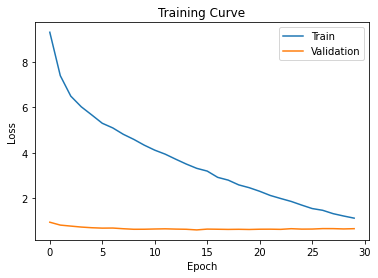

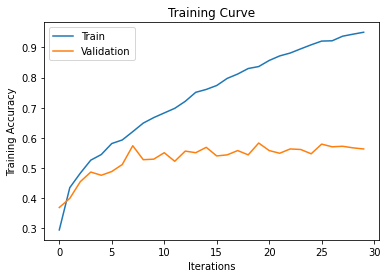

Final Training Accuracy: 0.950605038682801
Final Validation Accuracy: 0.5632798573975044


In [ ]:
plot_curves(train_loss, val_loss, train_acc, val_acc, iters)

####**7.2 ANN, Remove Dropout**

In [ ]:
use_cuda = True
batch_size = 128 
num_epochs = 20
learning_rate=1e-5
weight_decay = 0
crossVal = False 
model_index = 1

kf = StratifiedKFold(n_splits=10)
kf.get_n_splits()

model_2,criterion_2,train_loss_2, val_loss_2, train_acc_2, val_acc_2, iters_2 = train_CrossValidation(crossVal = crossVal, model_index=model_index,batch_size=batch_size, num_epochs=num_epochs, learn_rate =learning_rate, smallData=False,datasetNum=2,weight_decay=weight_decay)

age_classes =  ['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '53-100+', '7-12']
train:  5041
val:  561
sample_count_train =  [632, 630, 630, 629, 630, 630, 630, 630]
sample_count_val =  [71, 70, 70, 70, 70, 70, 70, 70]
CUDA is available!  Training on GPU ...

Fold Number: 0
Training Started...

Epoch 0 - Training Accuracy: 0.33743304899821464, Train Loss: 0.591409650631249| Validation Accuracy: 0.43137254901960786,Validation Loss: 0.06554413493722677

Epoch 1 - Training Accuracy: 0.4768895060503868, Train Loss: 0.4664310310035944| Validation Accuracy: 0.48663101604278075,Validation Loss: 0.055459718219935894

Epoch 2 - Training Accuracy: 0.5314421741717913, Train Loss: 0.3989934492856264| Validation Accuracy: 0.5115864527629234,Validation Loss: 0.051007792353630066

Epoch 3 - Training Accuracy: 0.5774647887323944, Train Loss: 0.36101008486002684| Validation Accuracy: 0.5276292335115864,Validation Loss: 0.04814460501074791

Epoch 4 - Training Accuracy: 0.6232890299543742, Train Los

**Result:**

Remove dropout worsen the accuracy, overfit start earlier

model architecture 2 doesn't work

####**7.3 ANN, Add weight decay**


In [ ]:
use_cuda = True
batch_size = 32 
num_epochs = 20
learning_rate=1e-5
weight_decay = 1e-2
crossVal = False 
model_index = 0

kf = StratifiedKFold(n_splits=10)
kf.get_n_splits()

model_3,criterion_4,train_loss_3, val_loss_3, train_acc_3, val_acc_3, iters_3  = train_CrossValidation(crossVal = crossVal, model_index=model_index,batch_size=batch_size, num_epochs=num_epochs, learn_rate =learning_rate, smallData=False,datasetNum=2,weight_decay=weight_decay)

age_classes =  ['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '53-100+', '7-12']
train:  5041
val:  561
sample_count_train =  [632, 630, 630, 629, 630, 630, 630, 630]
sample_count_val =  [71, 70, 70, 70, 70, 70, 70, 70]
CUDA is available!  Training on GPU ...

Fold Number: 0
Training Started...

Epoch 0 - Training Accuracy: 0.30132910136877605, Train Loss: 9.320985153317451| Validation Accuracy: 0.37967914438502676,Validation Loss: 0.9425887763500214

Epoch 1 - Training Accuracy: 0.42808966474905774, Train Loss: 7.516583662480116| Validation Accuracy: 0.4295900178253119,Validation Loss: 0.8252877853810787

Epoch 2 - Training Accuracy: 0.4770878793890101, Train Loss: 6.6112022660672665| Validation Accuracy: 0.46167557932263814,Validation Loss: 0.7612804621458054

Epoch 3 - Training Accuracy: 0.5189446538385241, Train Loss: 6.124527178704739| Validation Accuracy: 0.46880570409982175,Validation Loss: 0.7227443028241396

Epoch 4 - Training Accuracy: 0.5494941479865106, Train Loss: 5.73

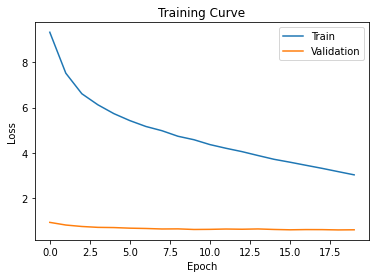

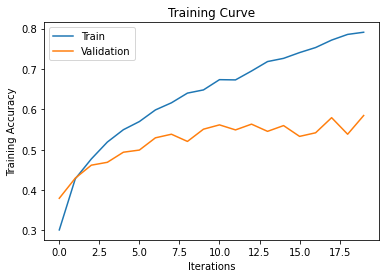

Final Training Accuracy: 0.7909145010910533
Final Validation Accuracy: 0.5846702317290553


In [ ]:
plot_curves(train_loss_3, val_loss_3, train_acc_3, val_acc_3, iters_3)

**Result:**

No Significant improvement

####**7.4 ANN, Add more Layers**



In [ ]:
use_cuda = True
batch_size = 32 
num_epochs = 30
learning_rate=1e-4
weight_decay = 0
crossVal = False 
model_index = 3

kf = StratifiedKFold(n_splits=10)
kf.get_n_splits()

model_4,criterion_4,train_loss_4, val_loss_4, train_acc_4, val_acc_4, iters_4  = train_CrossValidation(crossVal = crossVal, model_index=model_index,batch_size=batch_size, num_epochs=num_epochs, learn_rate =learning_rate, smallData=False,datasetNum=2,weight_decay=weight_decay)

age_classes =  ['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '53-100+', '7-12']
train:  5041
val:  561
sample_count_train =  [632, 630, 630, 629, 630, 630, 630, 630]
sample_count_val =  [71, 70, 70, 70, 70, 70, 70, 70]
CUDA is available!  Training on GPU ...

Fold Number: 0
Training Started...

Epoch 0 - Training Accuracy: 0.18190835151755605, Train Loss: 9.940893538296223| Validation Accuracy: 0.22994652406417113,Validation Loss: 1.0001892261207104

Epoch 1 - Training Accuracy: 0.356873636183297, Train Loss: 7.730216294527054| Validation Accuracy: 0.38146167557932265,Validation Loss: 0.8293369561433792

Epoch 2 - Training Accuracy: 0.44614163856377703, Train Loss: 6.569703923538327| Validation Accuracy: 0.48128342245989303,Validation Loss: 0.7707418203353882

Epoch 3 - Training Accuracy: 0.4887919063677842, Train Loss: 5.9740066938102245| Validation Accuracy: 0.49376114081996436,Validation Loss: 0.7142596878111362

Epoch 4 - Training Accuracy: 0.5314421741717913, Train Loss: 5.46

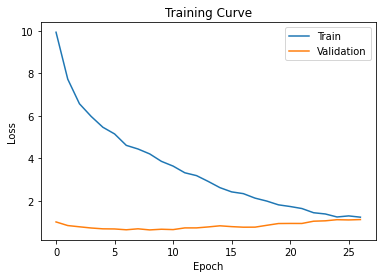

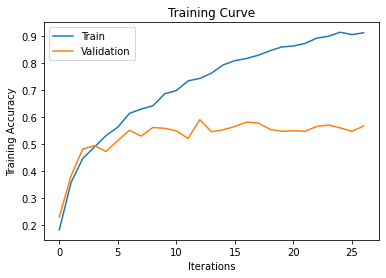

Final Training Accuracy: 0.9119222376512597
Final Validation Accuracy: 0.5668449197860963


In [ ]:
plot_curves(train_loss_4, val_loss_4, train_acc_4, val_acc_4, iters_4)

age_classes =  ['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '53-100+', '7-12']
train:  5041
val:  561
sample_count_train =  [632, 630, 630, 629, 630, 630, 630, 630]
sample_count_val =  [71, 70, 70, 70, 70, 70, 70, 70]
CUDA is available!  Training on GPU ...

Fold Number: 0
Training Started...

Finished Training
Total time elapsed: 158.23 seconds
Final Train Accuracy: 0.8629240230113073,Validation Accuracy: 0.5543672014260249, Train Loss: 1.7975315460935235, Validation Loss: 0.9145243465900421


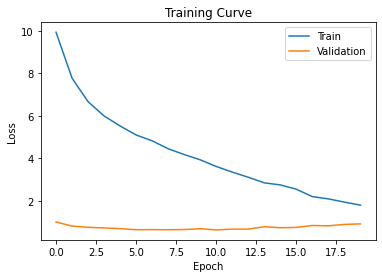

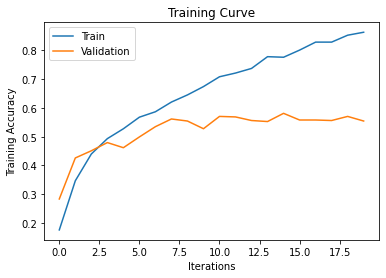

Final Training Accuracy: 0.8629240230113073
Final Validation Accuracy: 0.5543672014260249
train:  5041
val:  561
sample_count_train =  [632, 630, 630, 629, 630, 630, 630, 630]
sample_count_val =  [71, 70, 70, 70, 70, 70, 70, 70]
CUDA is available!  Training on GPU ...

Fold Number: 1
Training Started...

Finished Training
Total time elapsed: 160.02 seconds
Final Train Accuracy: 0.8609402896250744,Validation Accuracy: 0.5401069518716578, Train Loss: 1.8042650357820094, Validation Loss: 0.9824040234088898


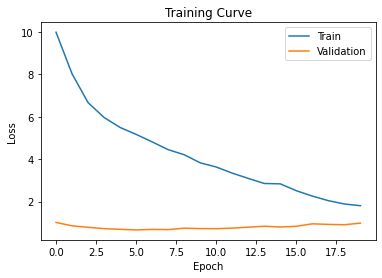

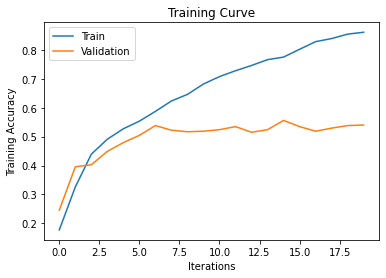

Final Training Accuracy: 0.8609402896250744
Final Validation Accuracy: 0.5401069518716578
train:  5042
val:  560
sample_count_train =  [632, 630, 630, 630, 630, 630, 630, 630]
sample_count_val =  [71, 70, 70, 69, 70, 70, 70, 70]
CUDA is available!  Training on GPU ...

Fold Number: 2
Training Started...

Finished Training
Total time elapsed: 159.72 seconds
Final Train Accuracy: 0.8637445458151527,Validation Accuracy: 0.5732142857142857, Train Loss: 1.818052832968533, Validation Loss: 0.8093657866120338


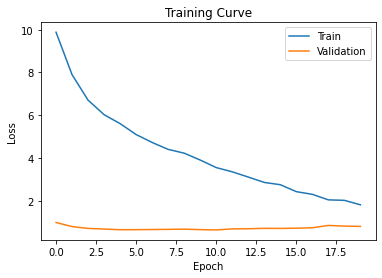

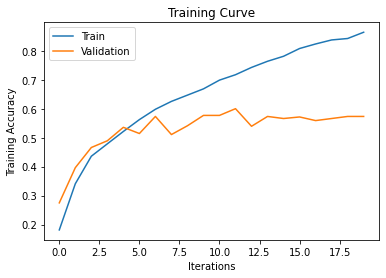

Final Training Accuracy: 0.8637445458151527
Final Validation Accuracy: 0.5732142857142857
train:  5042
val:  560
sample_count_train =  [633, 630, 630, 629, 630, 630, 630, 630]
sample_count_val =  [70, 70, 70, 70, 70, 70, 70, 70]
CUDA is available!  Training on GPU ...

Fold Number: 3
Training Started...

Finished Training
Total time elapsed: 158.22 seconds
Final Train Accuracy: 0.8542245140817136,Validation Accuracy: 0.5232142857142857, Train Loss: 1.9063285537995398, Validation Loss: 1.0704877339303493


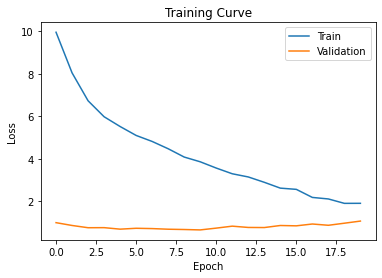

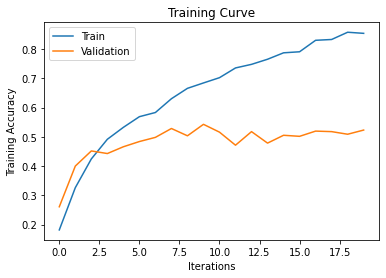

Final Training Accuracy: 0.8542245140817136
Final Validation Accuracy: 0.5232142857142857
train:  5042
val:  560
sample_count_train =  [633, 630, 630, 629, 630, 630, 630, 630]
sample_count_val =  [70, 70, 70, 70, 70, 70, 70, 70]
CUDA is available!  Training on GPU ...

Fold Number: 4
Training Started...

Finished Training
Total time elapsed: 155.27 seconds
Final Train Accuracy: 0.8538278460928204,Validation Accuracy: 0.5142857142857142, Train Loss: 1.8663426493294537, Validation Loss: 1.0806323997676373


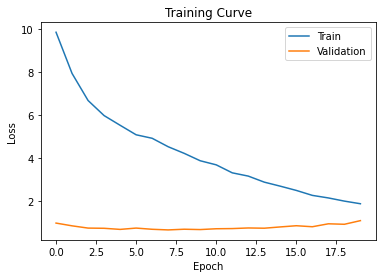

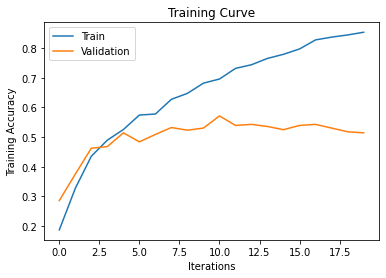

Final Training Accuracy: 0.8538278460928204
Final Validation Accuracy: 0.5142857142857142
train:  5042
val:  560
sample_count_train =  [633, 630, 630, 629, 630, 630, 630, 630]
sample_count_val =  [70, 70, 70, 70, 70, 70, 70, 70]
CUDA is available!  Training on GPU ...

Fold Number: 5
Training Started...

Finished Training
Total time elapsed: 155.43 seconds
Final Train Accuracy: 0.8571995239984134,Validation Accuracy: 0.5428571428571428, Train Loss: 1.8689761580899358, Validation Loss: 1.025334432721138


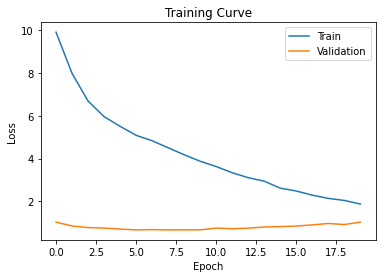

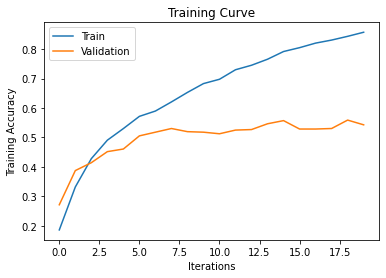

Final Training Accuracy: 0.8571995239984134
Final Validation Accuracy: 0.5428571428571428
train:  5042
val:  560
sample_count_train =  [633, 630, 630, 629, 630, 630, 630, 630]
sample_count_val =  [70, 70, 70, 70, 70, 70, 70, 70]
CUDA is available!  Training on GPU ...

Fold Number: 6
Training Started...

Finished Training
Total time elapsed: 153.25 seconds
Final Train Accuracy: 0.859579531931773,Validation Accuracy: 0.5321428571428571, Train Loss: 1.8424780096393079, Validation Loss: 0.9896501079201698


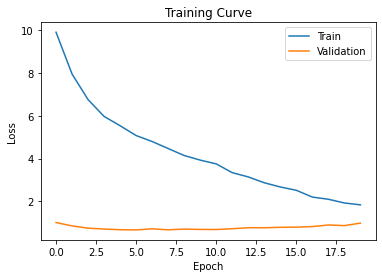

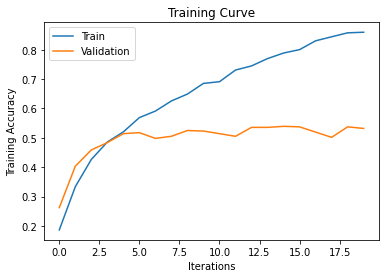

Final Training Accuracy: 0.859579531931773
Final Validation Accuracy: 0.5321428571428571
train:  5042
val:  560
sample_count_train =  [633, 630, 630, 629, 630, 630, 630, 630]
sample_count_val =  [70, 70, 70, 70, 70, 70, 70, 70]
CUDA is available!  Training on GPU ...

Fold Number: 7
Training Started...

Finished Training
Total time elapsed: 154.25 seconds
Final Train Accuracy: 0.8655295517651725,Validation Accuracy: 0.5, Train Loss: 1.795314917806536, Validation Loss: 1.0450152903795242


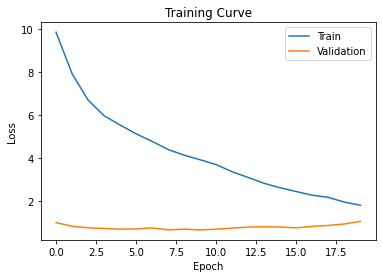

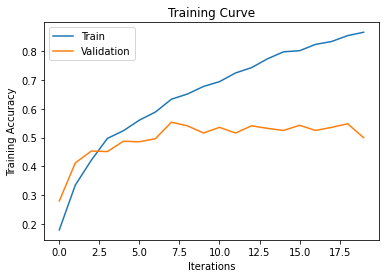

Final Training Accuracy: 0.8655295517651725
Final Validation Accuracy: 0.5
train:  5042
val:  560
sample_count_train =  [633, 630, 630, 629, 630, 630, 630, 630]
sample_count_val =  [70, 70, 70, 70, 70, 70, 70, 70]
CUDA is available!  Training on GPU ...

Fold Number: 8
Training Started...

Finished Training
Total time elapsed: 154.32 seconds
Final Train Accuracy: 0.859579531931773,Validation Accuracy: 0.5303571428571429, Train Loss: 1.8217782913707197, Validation Loss: 0.938000462949276


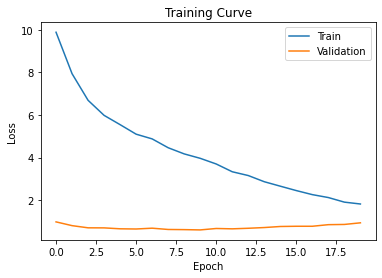

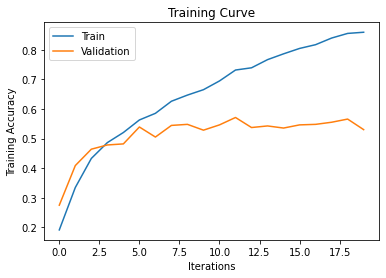

Final Training Accuracy: 0.859579531931773
Final Validation Accuracy: 0.5303571428571429
train:  5042
val:  560
sample_count_train =  [633, 630, 630, 629, 630, 630, 630, 630]
sample_count_val =  [70, 70, 70, 70, 70, 70, 70, 70]
CUDA is available!  Training on GPU ...

Fold Number: 9
Training Started...

Finished Training
Total time elapsed: 159.15 seconds
Final Train Accuracy: 0.8556128520428401,Validation Accuracy: 0.5553571428571429, Train Loss: 1.8734413185156882, Validation Loss: 0.8533103466033936


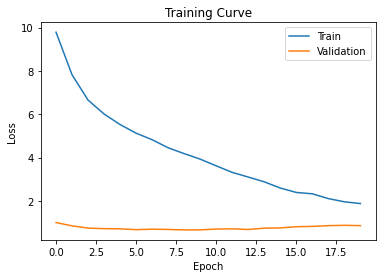

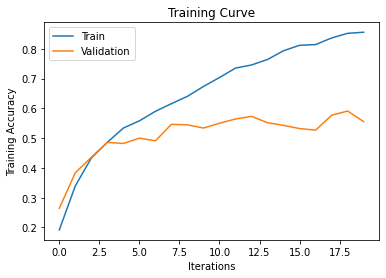

Final Training Accuracy: 0.8556128520428401
Final Validation Accuracy: 0.5553571428571429

 Average Train Accuracy: 0.8593162210296041, Val Accuracy: 0.5365902724726254


In [ ]:
use_cuda = True
batch_size = 32 
num_epochs = 30
learning_rate=1e-4
weight_decay = 0
crossVal = True 
model_index = 3

kf = StratifiedKFold(n_splits=10)
kf.get_n_splits()

model_4_cross,criterion_4_cross,train_loss_4_cross, val_loss_4_cross, train_acc_4_cross, val_acc_4_cross, iters_4_cross  = train_CrossValidation(crossVal = crossVal, model_index=model_index,batch_size=batch_size, num_epochs=num_epochs, learn_rate =learning_rate, smallData=False,datasetNum=2,weight_decay=weight_decay)

####7.5 ANN,Try to reduce weight decay

Based on 7.4

In [ ]:
use_cuda = True
batch_size = 32 
num_epochs = 20
learning_rate=1e-4
weight_decay = 1e-4
crossVal = False 
model_index = 3

kf = StratifiedKFold(n_splits=10)
kf.get_n_splits()

model_5,criterion_5,train_loss_5, val_loss_5, train_acc_5, val_acc_5, iters_5  = train_CrossValidation(crossVal = crossVal, model_index=model_index,batch_size=batch_size, num_epochs=num_epochs, learn_rate =learning_rate, smallData=False,datasetNum=2,weight_decay=weight_decay)

age_classes =  ['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '53-100+', '7-12']
train:  5041
val:  561
sample_count_train =  [632, 630, 630, 629, 630, 630, 630, 630]
sample_count_val =  [71, 70, 70, 70, 70, 70, 70, 70]
CUDA is available!  Training on GPU ...

Fold Number: 0
Training Started...

Epoch 0 - Training Accuracy: 0.17595715135885737, Train Loss: 10.010192528367043| Validation Accuracy: 0.24420677361853832,Validation Loss: 1.034025527536869

Epoch 1 - Training Accuracy: 0.3348541955961119, Train Loss: 7.941748488694429| Validation Accuracy: 0.42245989304812837,Validation Loss: 0.8379427567124367

Epoch 2 - Training Accuracy: 0.428288038087681, Train Loss: 6.7393635883927345| Validation Accuracy: 0.43315508021390375,Validation Loss: 0.7584260292351246

Epoch 3 - Training Accuracy: 0.4935528664947431, Train Loss: 5.9816297721117735| Validation Accuracy: 0.47058823529411764,Validation Loss: 0.7002521604299545

Epoch 4 - Training Accuracy: 0.5288633207696886, Train Loss: 5.46

**Result:**

No Significant improvement

####**7.6 ANN, Try Leaky_relu**

In [ ]:
use_cuda = True
batch_size = 32 
num_epochs = 50
learning_rate=1e-5
weight_decay = 1e-5
crossVal = False 
model_index = 6

kf = StratifiedKFold(n_splits=10)
kf.get_n_splits()

model_6,criterion_6,train_loss_6, val_loss_6, train_acc_6, val_acc_6, iters_6  = train_CrossValidation(crossVal = crossVal, model_index=model_index,batch_size=batch_size, num_epochs=num_epochs, learn_rate =learning_rate, smallData=False,datasetNum=2,weight_decay=weight_decay)

age_classes =  ['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '53-100+', '7-12']
train:  5041
val:  561
sample_count_train =  [632, 630, 630, 629, 630, 630, 630, 630]
sample_count_val =  [71, 70, 70, 70, 70, 70, 70, 70]
CUDA is available!  Training on GPU ...

Fold Number: 0
Training Started...

Epoch 0 - Training Accuracy: 0.14520928387224757, Train Loss: 10.249063491821289| Validation Accuracy: 0.15151515151515152,Validation Loss: 1.1642659679055214

Epoch 1 - Training Accuracy: 0.21007736560206308, Train Loss: 10.095828037708998| Validation Accuracy: 0.22459893048128343,Validation Loss: 1.1355381309986115

Epoch 2 - Training Accuracy: 0.26145606030549495, Train Loss: 9.630869194865227| Validation Accuracy: 0.29233511586452765,Validation Loss: 1.0645574368536472

Epoch 3 - Training Accuracy: 0.30807379488196784, Train Loss: 8.808652151376009| Validation Accuracy: 0.32976827094474154,Validation Loss: 0.9711406640708447

Epoch 4 - Training Accuracy: 0.35231104939496133, Train Loss:

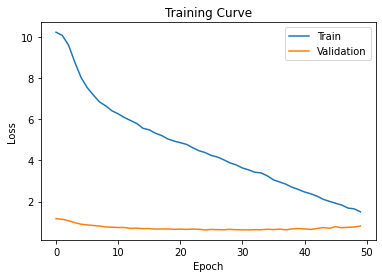

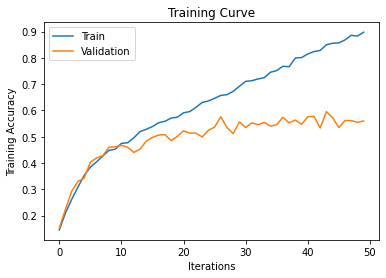

Final Training Accuracy: 0.8974409839317595
Final Validation Accuracy: 0.5597147950089126


In [ ]:
plot_curves(train_loss_6, val_loss_6, train_acc_6, val_acc_6, iters_6 )

**Result:**

Improve Accuracy by 2%

####**7.7 ANN Try PRelu**


And Change dropout rate to 0.2 

In [ ]:
use_cuda = True
batch_size = 32 
num_epochs = 50
learning_rate=1e-5
weight_decay = 0
crossVal = False 
model_index = 7
feature_path='/Debug_PreCropped6'

kf = StratifiedKFold(n_splits=10)
kf.get_n_splits()

model_7,criterion_7,train_loss_7, val_loss_7, train_acc_7, val_acc_7, iters_7  = train_CrossValidation(feature_path=feature_path,crossVal = crossVal, model_index=model_index,batch_size=batch_size, num_epochs=num_epochs, learn_rate =learning_rate, smallData=False,datasetNum=2,weight_decay=weight_decay)

age_classes =  ['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '53-100+', '7-12']
train:  7200
val:  800
sample_count_train =  [900, 900, 900, 900, 900, 900, 900, 900]
sample_count_val =  [100, 100, 100, 100, 100, 100, 100, 100]
CUDA is available!  Training on GPU ...

Fold Number: 0
Training Started...

Epoch 0 - Training Accuracy: 0.30069444444444443, Train Loss: 13.222145669162273| Validation Accuracy: 0.385,Validation Loss: 1.2189782559871674

Epoch 1 - Training Accuracy: 0.42625, Train Loss: 10.043348655104637| Validation Accuracy: 0.4575,Validation Loss: 1.048212245106697

Epoch 2 - Training Accuracy: 0.4855555555555556, Train Loss: 8.852388318628073| Validation Accuracy: 0.49125,Validation Loss: 0.9858239740133286

Epoch 3 - Training Accuracy: 0.5205555555555555, Train Loss: 8.201227447018027| Validation Accuracy: 0.50375,Validation Loss: 0.9399181567132473

Epoch 4 - Training Accuracy: 0.5633333333333334, Train Loss: 7.556910060346127| Validation Accuracy: 0.52375,Validation

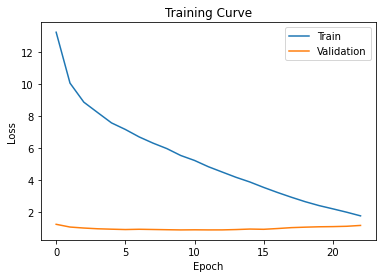

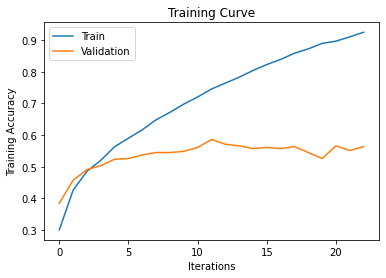

Val Accuracy Max =  0.58625
Final Training Accuracy: 0.9248611111111111
Final Validation Accuracy: 0.56375


In [ ]:
plot_curves(train_loss_7, val_loss_7, train_acc_7, val_acc_7, iters_7)

**Result:**

Improve Accuracy to 58%-61%

#####Use Cross Validation to choose best model

In [ ]:
use_cuda = True
batch_size = 32 
num_epochs = 50
learning_rate=1e-5
weight_decay = 0
crossVal = True 
model_index = 0

feature_path='/Debug_PreCropped6'

kf = StratifiedKFold(n_splits=10)
kf.get_n_splits()

model_7_list,criterion_7_cross,train_loss_7_cross, val_loss_7_cross, train_acc_7_cross, val_acc_7_cross, iters_7_cross  = train_CrossValidation(feature_path=feature_path,crossVal = crossVal, model_index=model_index,batch_size=batch_size, num_epochs=num_epochs, learn_rate =learning_rate, smallData=False,datasetNum=2,weight_decay=weight_decay)

age_classes =  ['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '53-100+', '7-12']
train:  7200
val:  800


KeyboardInterrupt: ignored

####**7.8 Try CNN**

In [ ]:
use_cuda = True
batch_size = 32 
num_epochs = 50
learning_rate=1e-5
weight_decay = 0
crossVal = False 
model_index = 8

kf = StratifiedKFold(n_splits=10)
kf.get_n_splits()

model_8,criterion_8,train_loss_8, val_loss_8, train_acc_8, val_acc_8, iters_8  = train_CrossValidation(crossVal = crossVal, model_index=model_index,batch_size=batch_size, num_epochs=num_epochs, learn_rate =learning_rate, smallData=False,datasetNum=2,weight_decay=weight_decay)

age_classes =  ['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '53-100+', '7-12']
train:  5041
val:  561
sample_count_train =  [632, 630, 630, 629, 630, 630, 630, 630]
sample_count_val =  [71, 70, 70, 70, 70, 70, 70, 70]
CUDA is available!  Training on GPU ...

Fold Number: 0
Training Started...

Epoch 0 - Training Accuracy: 0.14382067050188455, Train Loss: 10.226086884737015| Validation Accuracy: 0.23707664884135474,Validation Loss: 1.15567447245121

Epoch 1 - Training Accuracy: 0.2916088077762349, Train Loss: 9.917239896953106| Validation Accuracy: 0.32976827094474154,Validation Loss: 1.0914212800562382

Epoch 2 - Training Accuracy: 0.34973219599285854, Train Loss: 8.949574381113052| Validation Accuracy: 0.3850267379679144,Validation Loss: 0.9697219431400299

Epoch 3 - Training Accuracy: 0.3892084903788931, Train Loss: 7.995977606624365| Validation Accuracy: 0.3761140819964349,Validation Loss: 0.8974428549408913

Epoch 4 - Training Accuracy: 0.4124181709978179, Train Loss: 7.49284

**Result:**

Didn't improve accuracy effectively, and increase training loss

####**7.9 ANN, Increase Layer numbe to 8**

In [ ]:
use_cuda = True
batch_size = 32 
num_epochs = 50
learning_rate=1e-5
weight_decay = 0
crossVal = False 
model_index = 9

kf = StratifiedKFold(n_splits=10)
kf.get_n_splits()

model_9,criterion_9,train_loss_9, val_loss_9, train_acc_9, val_acc_9, iters_9  = train_CrossValidation(crossVal = crossVal, model_index=model_index,batch_size=batch_size, num_epochs=num_epochs, learn_rate =learning_rate,datasetNum=2,weight_decay=weight_decay)

age_classes =  ['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '53-100+', '7-12']
train:  5041
val:  561
sample_count_train =  [632, 630, 630, 629, 630, 630, 630, 630]
sample_count_val =  [71, 70, 70, 70, 70, 70, 70, 70]
CUDA is available!  Training on GPU ...

Fold Number: 0
Training Started...

Epoch 0 - Training Accuracy: 0.12497520333267209, Train Loss: 10.271579883992672| Validation Accuracy: 0.11586452762923351,Validation Loss: 1.1690694093704224

Epoch 1 - Training Accuracy: 0.13330688355485024, Train Loss: 10.267780743539333| Validation Accuracy: 0.14260249554367202,Validation Loss: 1.1670241504907608

Epoch 2 - Training Accuracy: 0.14957349732195993, Train Loss: 10.25513607263565| Validation Accuracy: 0.17290552584670232,Validation Loss: 1.167232684791088

Epoch 3 - Training Accuracy: 0.18170997817893275, Train Loss: 10.204245314002037| Validation Accuracy: 0.21390374331550802,Validation Loss: 1.1584557890892029

Epoch 4 - Training Accuracy: 0.22634397936917278, Train Loss:

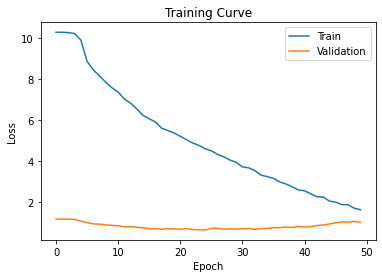

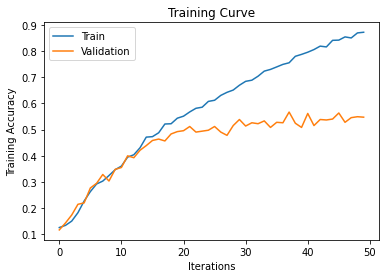

Final Training Accuracy: 0.8722475699266019
Final Validation Accuracy: 0.5472370766488414


In [ ]:
plot_curves(train_loss_9, val_loss_9, train_acc_9, val_acc_9, iters_9 )

####**Save model to google drive**

In [ ]:
print(len(model_7))

1


In [ ]:
model_save = model_7[0]
model_save.eval()

AlexnetClassifier_PR(
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=8, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (PReLU): PReLU(num_parameters=1)
)

In [ ]:
#manully compare 10 models in the model list

finalAccuracy = 0.55375
modelIndex =  7
batch_size = 32 
lr = 1e-5
epoch=50

model_path='/content/gdrive/My Drive/APS360 Group9 Project/Project/Models/'


path = "Balance_Accuracy_{finalAccuracy}_modelIndex_{modelIndex}_bs_{batch_size}_lr_{lr}_epoch_{epoch}.pt".format(
                                                  finalAccuracy=finalAccuracy,
                                                   modelIndex=modelIndex,
                                                   batch_size=batch_size,
                                                   lr=lr,
                                                   epoch=epoch)
torch.save(model_save.state_dict(), model_path+path)

###**Run Test dataset using best model**

In [ ]:
def get_accuracy_printError(model, data_loader):
    correct = 0
    total = 0
    image_false=[]
    index=0
    for imgs, labels in data_loader:
        
        # print('imgs=',imgs)
        # print('imgs[0]=',imgs[0])
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]

       
        TF = pred.eq(labels.view_as(pred))
        # print('TFList=',TF[0].item())
        labelList = labels.view_as(pred)
        # print('labelList=',labelList[0].item())
        # print('pred=',pred[0].item())

        if (TF == False):
          image_false.append([labelList[0].item(),pred[0].item(),index])

        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

        index+=1
        
    return correct / total, image_false

In [ ]:
#Test

batch_size = 1
feature_test_set = torchvision.datasets.DatasetFolder('/content/gdrive/My Drive/APS360 Group9 Project/Project/Features/PreCropped_Test', loader=torch.load, extensions=('.tensor'))


feature_test_loader = torch.utils.data.DataLoader(feature_test_set, batch_size=batch_size,
                                          num_workers=1)

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
def get_Alex_Features(data_loader):
  result = []
  for imgs, labels in iter(data_loader):
    features = alexnet.features(imgs)
    result.append((features, labels,imgs))
  return result

In [ ]:
def convert_type(features):
  result = []
  image_list = []
  for feature,label,img in iter(features):
    # print(img)
    # print(feature)
    # print(label)
    result.append((torch.from_numpy(feature.detach().numpy()), torch.from_numpy(label.detach().numpy())))
    image_list.append((img,label))
  return result,image_list

In [ ]:
model_test_balance = get_model(7)
model_test_balance.eval()

model_test_final = get_model(7)
model_test_final.eval()

AlexnetClassifier_PR(
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=200, bias=True)
  (fc5): Linear(in_features=200, out_features=8, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (PReLU): PReLU(num_parameters=1)
)

In [ ]:
# load_path = '/content/gdrive/My Drive/APS360 Group9 Project/Project/Models/Accuracy_0.58467_modelIndex_7_bs_32_lr_1e-05_epoch_50.pt'

load_path = '/content/gdrive/My Drive/APS360 Group9 Project/Project/Models/Balance_Accuracy_0.55375_modelIndex_7_bs_32_lr_1e-05_epoch_50.pt'
model_test_balance.load_state_dict(torch.load(load_path))
# model_test.eval()

load_path_final = '/content/gdrive/My Drive/APS360 Group9 Project/Project/Models/Accuracy_0.58467_modelIndex_7_bs_32_lr_1e-05_epoch_50.pt'
model_test_final.load_state_dict(torch.load(load_path_final))
# model_test.eval()



<All keys matched successfully>

#### **Test images: extract features from images**

In [ ]:
#Test

batch_size = 1

transform = transforms.Compose(
    [ transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset_test = torchvision.datasets.ImageFolder(root='/content/gdrive/My Drive/APS360 Group9 Project/Project/Dataset/Test_PreCropped',
                                                    transform=transform)
dataset_test_ageClass = dataset_test.classes
dataset_test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size,
                                          num_workers=1)


In [ ]:
test_featureList = get_Alex_Features(dataset_test_loader)
torch.save(test_featureList, 'test_featureList.pt')

In [ ]:
test_feature_list = torch.load('test_featureList.pt')
test_feature_list_convert,image_list = convert_type(test_feature_list)

#### **Get accuracy and print false images**

In [ ]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model_test_final.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

test_acc_test,image_false = get_accuracy_printError(model_test_final,test_feature_list_convert)

CUDA is available!  Training on GPU ...


In [ ]:
 #With Unbalanced dataset: 
 print(("Test Accuracy: {}").format(test_acc_test))

Test Accuracy: 0.5946632782719187


In [ ]:
if use_cuda and torch.cuda.is_available():
  model_test_balance.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
test_acc_test_balance,image_false_balance = get_accuracy_printError(model_test_balance,test_feature_list_convert)
 #With balanced dataset: 
print(("Test Accuracy: {}").format(test_acc_test_balance))

RuntimeError: ignored

In [ ]:
def print_false_images(image_false,age_class,num_images):
  print(len(image_false))
  k = 0
  for each in image_false:
    imgIndex = each[2]
    img = image_list[imgIndex][0]
    img = img[0]

    title = 'Label: ' + age_class[each[0]] + '  Model Prediction Result: ' + age_class[each[1]]
    image = np.transpose(img, [1,2,0])

    image = image / 2 + 0.5
    f = plt.figure()
    plt.axis('off')
    plt.title(title)
    plt.imshow(image)

    k+=1
    if k>num_images:
      break

In [ ]:
print_false_images(image_false,dataset_test_ageClass,200)

Output hidden; open in https://colab.research.google.com to view.

### **Confusion Matrix** 

Build confusion matrix for on best model so far

In [ ]:
def confusionMatrix_Cross(model,batch_size=32,feature_path='/PreCropped'):

    feature_set = torchvision.datasets.DatasetFolder(features_master_path+feature_path, loader=torch.load, extensions=('.tensor'))
    
    age_classes = feature_set.classes

    print('age_classes = ',age_classes)

    for i,(train_i, val_i) in enumerate(kf.split(feature_set,np.array(feature_set.targets))):

      print('train: ',len(train_i))
      print('val: ',len(val_i))


      num_workers = 1
      train_i=train_i.tolist()
      train_sampler = SubsetRandomSampler(train_i)
      train_loader = torch.utils.data.DataLoader(feature_set, batch_size=batch_size,
                                              num_workers=num_workers, sampler=train_sampler)
      
      val_i=val_i.tolist()
      val_sampler = SubsetRandomSampler(val_i)
      val_loader = torch.utils.data.DataLoader(feature_set, batch_size=batch_size,
                                              num_workers=num_workers, sampler=val_sampler)
      
      sample_count_train = get_sample_num(train_loader,len(age_classes))
      sample_count_val = get_sample_num(val_loader,len(age_classes))

      print('sample_count_train = ',sample_count_train)
      print('sample_count_val = ',sample_count_val)
     
      if use_cuda and torch.cuda.is_available():
        model.cuda()
        print('CUDA is available!  Training on GPU ...')
      else:
        print('CUDA is not available.  Training on CPU ...')

      print("\nFold Number: {}".format(i))
      y_pred_train,y_true_train= confusion_cross_sub(model, train_loader, batch_size)
      y_pred_val,y_true_val= confusion_cross_sub(model, val_loader, batch_size)

      break;
      

    return y_pred_train,y_true_train,y_pred_val,y_true_val,age_classes

In [ ]:
def confusion_cross_sub(model, data_loader, batch_size):
    
  torch.manual_seed(1000)
  criterion = nn.CrossEntropyLoss()

  y_true,y_pred=[],[]

  for imgs, labels in iter(data_loader):
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()

      out = model(imgs)             # forward pass
      
      pred = out.max(1, keepdim=True)[1]
      # print('pred=',pred)
     
      labelList = labels.view_as(pred)
      # print('labelList=',labelList)
      for i, eachPred in  enumerate(pred):
        y_pred.append(eachPred[0].item())
        y_true.append(labelList[i][0].item())
      
  return y_pred,y_true


In [ ]:
from decimal import Decimal

def get_acc_percentage(df):
  result = []
  acc_average = 0
  for each in age_classes_master:
    temp = (df[each][each]/df.sum(axis=1)[each])*100
    acc_average += temp
    temp = round(Decimal(temp),2)
    result.append(str(temp)+'%')

  acc_average = acc_average/len(age_classes_master)
  return result,acc_average
  

In [ ]:
def get_pd_table(y_true_train, y_pred_train,age_classes):
  print(age_classes)
  result_table = confusion_matrix(y_true_train, y_pred_train, labels = [0,1,2,3,4,5,6,7])
  result_table = pd.DataFrame(result_table,columns=[0,1,2,3,4,5,6,7])
  result_table = result_table.rename(columns={0: age_classes[0],
                                       1: age_classes[1],
                                       2:age_classes[2],
                                       3:age_classes[3],
                                       4:age_classes[4],
                                       5:age_classes[5],
                                       6:age_classes[6],
                                       7:age_classes[7]
                                       },
                              index= {0: age_classes[0],
                                       1: age_classes[1],
                                       2:age_classes[2],
                                       3:age_classes[3],
                                       4:age_classes[4],
                                       5:age_classes[5],
                                       6:age_classes[6],
                                       7:age_classes[7]})
  result_table = result_table.reindex(index=age_classes_master,columns=age_classes_master)
  accuacy,acc_average = get_acc_percentage(result_table)
  result_table['Accuracy'] = accuacy

  return result_table,acc_average

#### **Best Model_1: model_7 trained on unbalanced dataset**

In [ ]:
kf = StratifiedKFold(n_splits=10)
kf.get_n_splits()
use_cuda = True

y_pred_train,y_true_train,y_pred_val,y_true_val,age_classes = confusionMatrix_Cross(model_test,batch_size=32)

age_classes =  ['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '53-100+', '7-12']
train:  5041
val:  561
sample_count_train =  [632, 630, 630, 629, 630, 630, 630, 630]
sample_count_val =  [71, 70, 70, 70, 70, 70, 70, 70]
CUDA is available!  Training on GPU ...

Fold Number: 0


In [ ]:
age_classes[-2] = age_classes[-2] = '54-100+'
age_classes

['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '54-100+', '7-12']

In [ ]:
#train data table
# age_classes[-2] = '54-100+'
train_table,train_acc_average = get_pd_table(y_true_train,y_pred_train,age_classes)
temp_train  = round(Decimal(train_acc_average),2)
print('Average Accuracy = ',str(temp_train)+'%')

train_table

['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '54-100+', '7-12']
Average Accuracy =  95.00%


,0-2,3-6,7-12,13-20,21-32,33-43,44-53,54-100+,Accuracy
0-2,632,0,0,0,0,0,0,0,100.00%
3-6,16,608,5,0,0,0,0,0,96.66%
7-12,1,10,606,13,0,0,0,0,96.19%
13-20,0,0,7,616,7,0,0,0,97.78%
21-32,0,1,0,5,605,19,0,0,96.03%
33-43,0,0,0,2,30,592,5,1,93.97%
44-53,0,0,0,0,2,88,529,11,83.97%
54-100+,0,0,0,0,1,9,19,601,95.40%


In [ ]:
#val data table

val_table,val_acc_average = get_pd_table(y_true_val, y_pred_val,age_classes)
temp_val = round(Decimal(val_acc_average),2)
print('Average Accuracy = ',str(temp_val)+'%')
val_table

['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '54-100+', '7-12']
Average Accuracy =  61.27%


,0-2,3-6,7-12,13-20,21-32,33-43,44-53,54-100+,Accuracy
0-2,63,7,0,0,0,0,1,0,88.73%
3-6,16,41,11,1,0,0,0,1,58.57%
7-12,0,10,40,17,1,0,0,2,57.14%
13-20,0,3,15,37,11,4,0,0,52.86%
21-32,1,0,2,7,38,19,3,0,54.29%
33-43,0,0,2,2,12,43,8,3,61.43%
44-53,0,0,2,1,4,20,31,12,44.29%
54-100+,0,0,1,1,0,8,9,51,72.86%


#### Aug 03: balanced dataset

In [ ]:
kf = StratifiedKFold(n_splits=10)
kf.get_n_splits()
feature_path='/Debug_PreCropped6'

y_pred_train_2,y_true_train_2,y_pred_val_2,y_true_val_2,age_classes_2 = confusionMatrix_Cross(model_7[0],batch_size=32,feature_path=feature_path)

age_classes =  ['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '53-100+', '7-12']
train:  7200
val:  800
sample_count_train =  [900, 900, 900, 900, 900, 900, 900, 900]
sample_count_val =  [100, 100, 100, 100, 100, 100, 100, 100]
CUDA is available!  Training on GPU ...

Fold Number: 0


In [ ]:
age_classes_2[-2]='54-100+'
age_classes_2

['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '54-100+', '7-12']

In [ ]:
#train data table
train_table_2,train_acc_average_2 = get_pd_table(y_true_train_2,y_pred_train_2,age_classes_2)
temp_train  = round(Decimal(train_acc_average_2),2)
print('Average Accuracy = ',str(temp_train)+'%')

train_table_2

['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '54-100+', '7-12']
Average Accuracy =  94.07%


,0-2,3-6,7-12,13-20,21-32,33-43,44-53,54-100+,Accuracy
0-2,886,13,1,0,0,0,0,0,98.44%
3-6,11,882,7,0,0,0,0,0,98.00%
7-12,0,8,887,5,0,0,0,0,98.56%
13-20,0,1,10,877,9,1,2,0,97.44%
21-32,1,0,0,102,736,54,7,0,81.78%
33-43,0,1,1,21,44,758,71,4,84.22%
44-53,0,0,1,2,2,8,867,20,96.33%
54-100+,0,0,0,0,0,2,18,880,97.78%


In [ ]:
#val data table

val_table_2,val_acc_average_2 = get_pd_table(y_true_val_2, y_pred_val_2,age_classes_2)
temp_val = round(Decimal(val_acc_average_2),2)
print('Average Accuracy = ',str(temp_val)+'%')
val_table_2

['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '54-100+', '7-12']
Average Accuracy =  55.00%


,0-2,3-6,7-12,13-20,21-32,33-43,44-53,54-100+,Accuracy
0-2,81,18,0,0,0,0,0,1,81.00%
3-6,13,61,20,4,0,0,1,1,61.00%
7-12,1,16,66,12,1,1,2,1,66.00%
13-20,0,4,15,52,15,6,5,3,52.00%
21-32,0,3,4,28,26,25,11,3,26.00%
33-43,0,0,4,15,13,33,25,10,33.00%
44-53,0,2,8,7,4,11,47,21,47.00%
54-100+,0,2,1,0,0,5,18,74,74.00%


## **Test: Train the model using more data**


##### **Based on 7.7**

In [ ]:
use_cuda = True
batch_size = 32 
num_epochs = 50
learning_rate=1e-5
weight_decay = 0
crossVal = False 
model_index = 7
feature_path='/Augmented_PreCropped'

kf = StratifiedKFold(n_splits=11)
kf.get_n_splits()

model_7__2,criterion_7_2,train_loss_7_2, val_loss_7_2, train_acc_7_2, val_acc_7_2, iters_7_2  = train_CrossValidation(feature_path=feature_path,crossVal = crossVal, model_index=model_index,batch_size=batch_size, num_epochs=num_epochs, learn_rate =learning_rate, smallData=False,datasetNum=2,weight_decay=weight_decay)

KeyboardInterrupt: ignored

In [ ]:
plot_curves(train_loss_7_2, val_loss_7_2, train_acc_7_2, val_acc_7_2, iters_7_2)

In [ ]:
y_pred_train_2,y_true_train_2,y_pred_val_2,y_true_val_2,age_classes_2 = confusionMatrix_Cross(model_7__2,batch_size=32,feature_path='/Augmented_PreCropped')

age_classes =  ['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '53-100+', '7-12']
train:  8913
val:  892
sample_count_train =  [1119, 1113, 1114, 1113, 1113, 1114, 1114, 1113]
sample_count_val =  [112, 112, 111, 111, 112, 111, 111, 112]
CUDA is available!  Training on GPU ...

Fold Number: 0


In [ ]:
train_conf_2 = confusion_matrix(y_true_train_2, y_pred_train_2, labels = [0,1,2,3,4,5,6,7])
print(age_classes_2)
df_2=pd.DataFrame(train_conf_2,columns=[0,1,2,3,4,5,6,7])
accuacy_2 = get_acc_percentage(df_2)
df_2['accuracy'] = accuacy_2
df_2

['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '53-100+', '7-12']


,0,1,2,3,4,5,6,7,accuracy
0,1084,0,0,35,0,0,0,0,98.36660617059891%
1,1,1069,14,2,1,0,0,26,92.63431542461005%
2,0,45,1024,2,34,7,0,2,91.18432769367764%
3,16,0,0,1081,0,1,0,15,94.41048034934498%
4,0,15,77,0,872,129,17,3,92.56900212314225%
5,0,2,8,1,35,996,72,0,85.42024013722127%
6,0,1,0,0,0,33,1079,1,92.38013698630137%
7,1,22,0,24,0,0,0,1066,95.77717879604673%


In [ ]:
val_conf_2=confusion_matrix(y_true_val_2, y_pred_val_2, labels = [0,1,2,3,4,5,6,7])
print(age_classes_2)
df_2_val=pd.DataFrame(val_conf_2,columns=[0,1,2,3,4,5,6,7])
accuacy_2_val = get_acc_percentage(df_2_val)
df_2_val['accuracy'] = accuacy_2_val
df_2_val

['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '53-100+', '7-12']


,0,1,2,3,4,5,6,7,accuracy
0,86,0,0,23,1,0,2,0,81.13207547169812%
1,2,60,15,4,1,4,2,24,49.586776859504134%
2,0,23,56,2,12,11,3,4,48.275862068965516%
3,17,4,2,70,0,1,0,17,60.86956521739131%
4,0,2,25,0,47,25,12,1,57.3170731707317%
5,1,7,9,2,15,50,25,2,45.87155963302752%
6,0,2,3,0,6,16,84,0,65.11627906976744%
7,0,23,6,14,0,2,1,66,57.89473684210527%


#####**Based on 7.9**

In [ ]:
use_cuda = True
batch_size = 32 
num_epochs = 50
learning_rate=1e-5
weight_decay = 0
crossVal = False 
model_index = 9

feature_path='/Augmented_PreCropped'

kf = StratifiedKFold(n_splits=11)
kf.get_n_splits()

model_9__2,criterion_9_2,train_loss_9_2, val_loss_9_2, train_acc_9_2, val_acc_9_2, iters_9_2  = train_CrossValidation(feature_path=feature_path,crossVal = crossVal, model_index=model_index,batch_size=batch_size, num_epochs=num_epochs, learn_rate =learning_rate, smallData=False,datasetNum=2,weight_decay=weight_decay)

age_classes =  ['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '53-100+', '7-12']
train:  8913
val:  892
sample_count_train =  [1119, 1113, 1114, 1113, 1113, 1114, 1114, 1113]
sample_count_val =  [112, 112, 111, 111, 112, 111, 111, 112]
CUDA is available!  Training on GPU ...

Fold Number: 0
Training Started...

Epoch 0 - Training Accuracy: 0.13037136766520813, Train Loss: 18.134546786546707| Validation Accuracy: 0.1491031390134529,Validation Loss: 1.8187892585992813

Epoch 1 - Training Accuracy: 0.13856165152025132, Train Loss: 18.09835433959961| Validation Accuracy: 0.15582959641255606,Validation Loss: 1.8086681589484215

Epoch 2 - Training Accuracy: 0.2136205542466061, Train Loss: 17.011006265878677| Validation Accuracy: 0.2533632286995516,Validation Loss: 1.5785057730972767

Epoch 3 - Training Accuracy: 0.2696061932009424, Train Loss: 14.952994082123041| Validation Accuracy: 0.3015695067264574,Validation Loss: 1.4826428815722466

Epoch 4 - Training Accuracy: 0.29754291484348705,

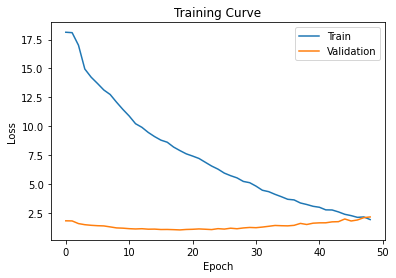

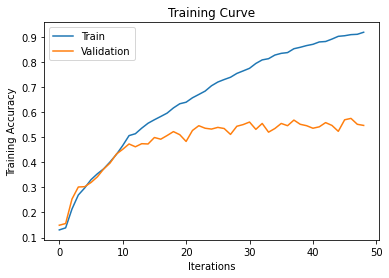

Final Training Accuracy: 0.9186581397958039
Final Validation Accuracy: 0.547085201793722


In [ ]:
plot_curves(train_loss_9_2, val_loss_9_2, train_acc_9_2, val_acc_9_2, iters_9_2)

In [ ]:
y_pred_train_3,y_true_train_3,y_pred_val_3,y_true_val_3,age_classes_3 = confusionMatrix_Cross(model_9__2,batch_size=32,feature_path='/Augmented_PreCropped')

age_classes =  ['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '53-100+', '7-12']
train:  8913
val:  892
sample_count_train =  [1119, 1113, 1114, 1113, 1113, 1114, 1114, 1113]
sample_count_val =  [112, 112, 111, 111, 112, 111, 111, 112]
CUDA is available!  Training on GPU ...

Fold Number: 0


In [ ]:
train_conf_3 = confusion_matrix(y_true_train_3, y_pred_train_3, labels = [0,1,2,3,4,5,6,7])
print(age_classes_3)
df_3 = pd.DataFrame(train_conf_3,columns=[0,1,2,3,4,5,6,7])
accuacy_3 = get_acc_percentage(df_3)
df_3['accuracy'] = accuacy_3
df_3

['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '53-100+', '7-12']


,0,1,2,3,4,5,6,7,accuracy
0,1103,0,0,16,0,0,0,0,99.45897204688909%
1,0,1039,10,0,0,2,0,62,85.51440329218107%
2,0,143,931,1,37,1,0,1,90.82926829268293%
3,5,0,0,1076,0,0,1,31,96.84968496849685%
4,1,3,82,0,899,128,0,0,91.92229038854805%
5,0,3,2,0,42,962,105,0,86.51079136690647%
6,0,0,0,0,0,19,1094,1,91.16666666666666%
7,0,27,0,18,0,0,0,1068,91.83147033533963%


In [ ]:
val_conf_3 = confusion_matrix(y_true_val_3, y_pred_val_3, labels = [0,1,2,3,4,5,6,7])
print(age_classes_3)
df_3_val=pd.DataFrame(val_conf_3,columns=[0,1,2,3,4,5,6,7])
accuacy_3_val = get_acc_percentage(df_3_val)
df_3_val['accuracy'] = accuacy_3_val
df_3_val

['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '53-100+', '7-12']


,0,1,2,3,4,5,6,7,accuracy
0,85,0,0,23,1,1,1,1,80.95238095238095%
1,1,63,16,2,1,4,2,23,43.75%
2,0,31,48,0,15,10,3,4,46.601941747572816%
3,19,2,0,61,1,1,0,27,59.80392156862745%
4,0,8,28,0,39,30,7,0,47.5609756097561%
5,0,8,8,1,19,47,25,3,40.51724137931034%
6,0,1,2,0,6,22,78,2,67.24137931034483%
7,0,31,1,15,0,1,0,64,51.61290322580645%


## **Step 5:Baseline Model**


In [ ]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import os
import cv2
print(cv2.__version__)
# example of face detection with opencv cascade classifier
from cv2 import imread
from cv2 import rectangle
from cv2 import imshow
from PIL import Image 
import numpy as np
from time import time
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from skimage import color
from skimage import io


4.1.2


Mount the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Processing the data using given dataset

In [ ]:
master_path = '/content/gdrive/My Drive/APS360 Group9 Project/Project/Dataset/Small Data'

age_classes = ['0-2','3-6','7-12','13-20','21-32','33-43','44-53','54-100+']

count = 0
images,labels = [],[]
for filename in os.listdir(master_path):
  for i in os.listdir(master_path + '/' + filename):
    img = cv2.imread(os.path.join(master_path + '/' + filename,i))  
    count+=1
    print(count)
    images.append(img)
    labels.append(filename)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


Sanity Check

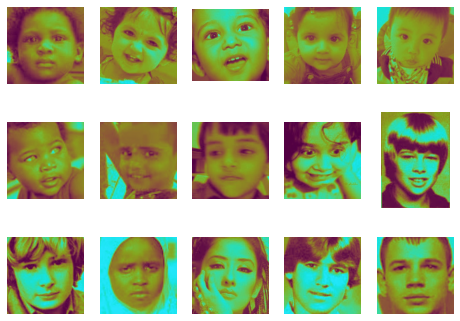

In [ ]:
figs = plt.figure(figsize=(8,6))
for i in range(15):
  plot = figs.add_subplot(3,5,i+1)
  plt.imshow(images[i])
  plt.axis('off')

Import the sklearn package to enable the knn training


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import kneighbors_graph
from sklearn import decomposition
import imutils

Extract the intensity of pixels and labels as the features

In [ ]:
# loop over the input images
rawImages = list()
features = list()
for i in range(len(images)):
  image = images[i]
  pixels = cv2.resize(image, (217, 217)).flatten()
  print(pixels)
  # feature =  extract_color_histogram(image)
  # update the raw images,
  # respectively
  rawImages.append(pixels)
  # features.append(feature)

[143 107  53 ... 138 151  36]
[138 119  38 ... 139 138  34]
[120  39  72 ... 123  43  74]
[ 31 230 239 ... 140 143  33]
[ 24 227 218 ... 142 125  38]
[117  37  72 ... 142 110  45]
[143  92  52 ... 139  92  54]
[102 198  84 ... 111  28  73]
[ 82   2  67 ...  96 204  98]
[134 154  31 ... 155 126  87]
[102 197  92 ... 136  96  48]
[ 67 215 143 ...  31 230 246]
[112 208  94 ... 135  73  67]
[141 130  38 ... 105 193  76]
[ 21 230 232 ... 137  76  62]
[141 152  30 ... 113  31  74]
[ 29 229 241 ...  59 221 163]
[ 27 227 233 ...  55 216 160]
[ 16 229 213 ... 112  30  73]
[ 26 229 238 ... 141 135  38]
[131 156  34 ... 144  92  56]
[ 35 232 248 ... 113  31  73]
[126 176  44 ... 133 166  32]
[134 160  30 ... 131  63  64]
[ 47 220 176 ... 141  87  56]
[120  55  54 ... 101  17  71]
[ 36 230 253 ...  35 230 250]
[141 123  40 ... 118 199  82]
[ 49 223 163 ... 131  57  69]
[146 103  54 ... 143 115  44]
[144 109  46 ... 128  52  70]
[ 36 230 253 ...  36 230 253]
[ 79 209 122 ...  28 228 240]


Split the data set into training and testing

In [ ]:
(trainRI, testRI, trainRL, testRL) = train_test_split(
	rawImages, labels, test_size=0.25, random_state=0)

The eigenface features start to run.....


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done


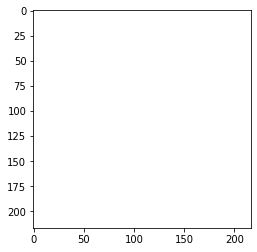

In [ ]:
print("The eigenface features start to run.....")
pca = decomposition.PCA(n_components=24, svd_solver='randomized',
          whiten=True).fit(trainRI)
trainRI_pca = pca.transform(trainRI)
testRI_pca = pca.transform(testRI)
print("Done" )

# plt.imshow(pca.mean_.reshape(images[0].shape),
#            cmap=plt.cm.bone)

Training the data and report the accuracy

In [ ]:
print("KNN Training start using eigefaces...")
model1 = KNeighborsClassifier(n_neighbors = 6)
model1.fit(trainRI_pca, trainRL)
accuracy = model1.score(testRI_pca, testRL)
print("The final accuracy for KNN is: {:.2f}%".format(accuracy * 100))

KNN Training start using eigefaces...
The final accuracy for KNN is: 22.22%


In [ ]:
print("KNN Training start using pixels...")
model2 = KNeighborsClassifier(n_neighbors = 6)
model2.fit(trainRI, trainRL)
accuracy = model2.score(testRI, testRL)
print("The final accuracy for KNN is: {:.2f}%".format(accuracy * 100))

KNN Training start using pixels...
The final accuracy for KNN is: 0.00%


Visualize the k-neighbors by diagram


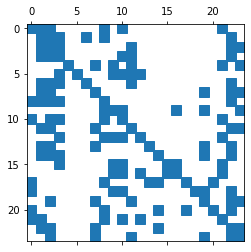

In [ ]:
a = kneighbors_graph(model2, 6, mode='connectivity', include_self=True)
plt.spy(a)
plt.show()

#For demo: Upload new data

Upload a new image and predict the age


In [ ]:
from io import BytesIO
from PIL import Image
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_eye.xml')

In [ ]:
model_demo = get_model(7)
model_demo.eval()
load_path = '/content/gdrive/My Drive/APS360 Group9 Project/Project/Models/Accuracy_0.58467_modelIndex_7_bs_32_lr_1e-05_epoch_50.pt'
# load_path = '/content/gdrive/My Drive/APS360 Group9 Project/Project/Models/Balance_Accuracy_0.55375_modelIndex_7_bs_32_lr_1e-05_epoch_50.pt'
model_demo.load_state_dict(torch.load(load_path))
# model_test.eval()


<All keys matched successfully>

In [ ]:
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
def get_face_ROI(img,padding):

  print('image type= ',type(img))
  faces = face_cascade.detectMultiScale(img, scaleFactor=1.02,minNeighbors =5) #face detection
  return_img = img
  return_crop= img
  prev_eye_count=0

  for box in faces:
    x, y, width, height = box
    x2, y2 = int(x + width), int(y + height)
  
    x = int(x-padding) if (x-padding>0) else x
    y = int(y-padding) if (y-padding>0) else y
    x2 = int(x2+padding) if (x2+padding<img.shape[1]) else x2
    y2 = int(y2+padding) if (y2+padding < img.shape[0]) else y2
    # rectangle(img, (int(x), int(y)), (x2, y2), (255, 0, 0), 2) # For testing, draw a rectangle around the face
    cropped = img[y:y2,x:x2]

    eyes = eye_cascade.detectMultiScale(cropped) # eye detection
   
    if len(eyes) >0:
      eye_count=0
      for (ex,ey,ew,eh) in eyes:
        eye_count+=1
        # cv2.rectangle(cropped,(ex,ey),(ex+ew,ey+eh),(0,255,0),2) # For testing, draw a rectangle around the eyes
      
      if eye_count > prev_eye_count:
        return_img = img
        return_crop = cropped
        prev_eye_count= eye_count
    
    return_crop = cv2.resize(return_crop,(224,224))

    # print('test=',return_img.dtype)

  return return_img,return_crop

In [ ]:
def get_age_rediction(image,model):
  
  print(type(image))
  # print(image)

  # if use_cuda and torch.cuda.is_available():
  #   image = image.cuda()

  output = model(image)
  age_predict = output.max(1, keepdim=True)[1]
  print(age_predict)

  return age_predict
    


In [ ]:
def get_demo_feature():
  #Method two: save image to colab and then retrieve it
  transform = transforms.Compose(
    [ transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  demo_dataset = torchvision.datasets.ImageFolder('/content/gdrive/My Drive/APS360 Group9 Project/Presentation/image_temp',
                                                    transform=transform)
  demo_loader = torch.utils.data.DataLoader(demo_dataset, batch_size=1,
                                                num_workers=1,shuffle = False)

  for each, label in demo_loader:
    # print(each)
    print(each.shape)
    image_feature = alexnet.features(each)
    print(image_feature.shape)
    features_tensor = torch.from_numpy(image_feature.detach().numpy())
    features_tensor=features_tensor.squeeze(0)
    print(features_tensor.shape)
    # print(image_feature)
    torch.save(features_tensor,'/content/gdrive/My Drive/APS360 Group9 Project/Presentation/image_temp/feature/Demo'+'.tensor')


  demo_feature_set = torchvision.datasets.DatasetFolder('/content/gdrive/My Drive/APS360 Group9 Project/Presentation/image_temp/feature', 
                                                  loader=torch.load, extensions=('.tensor'))
      
  demo_feature = torch.utils.data.DataLoader(demo_feature_set, batch_size=1,
                                                num_workers=1)

  for each,label in demo_feature:
    image_feature = each
  
  return image_feature

**Upload new image:**

In [ ]:
#upload a face image
uploaded = files.upload()

fileName,fileData=[],[]
for name, data in uploaded.items():
  fileName = name
  fileData = data


Saving download.png to download (1).png


In [ ]:
def processimage(image):
  image.savefig('/content/gdrive/My Drive/APS360 Group9 Project/Presentation/image_temp/3-6/Demo.jpg',
          quality=95,
            bbox_inches='tight',
            pad_inches=0.0)

image type=  <class 'numpy.ndarray'>


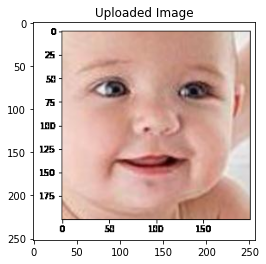

In [ ]:
padding=10

img = cv2.imread(fileName)
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #convert color channel from BGR to RGB

plt.figure()
plt.title('Uploaded Image')
plt.imshow(img_cvt)
img,cropped_result = get_face_ROI(img_cvt,padding)



FileNotFoundError: ignored

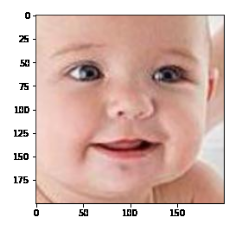

In [ ]:

# print("Cropped Image: ")
f = plt.figure()
plt.axis('off')
plt.imshow(cropped_result)

processimage(f)

In [ ]:
image_feature=get_demo_feature()

torch.Size([1, 3, 224, 224])
torch.Size([1, 256, 6, 6])
torch.Size([256, 6, 6])


In [ ]:
result = get_age_rediction(image_feature,model_7)

NameError: ignored

In [ ]:
from torch.utils.data import IterableDataset
import queue


class MyDataset(IterableDataset):
    def __init__(self, image_queue):
      self.queue = image_queue


    def read_next_image(self):
        while self.queue.qsize() > 0:
            # you can add transform here
            yield self.queue.get()
        return None

    def __iter__(self):
        return self.read_next_image()

In [ ]:
from PIL import Image
age_class = ['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '54-100+', '7-12']
norm = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))


print(cropped_result)
# print(cropped_result.shape)
# print(cropped_result.dtype)


cropped_result = cropped_result.astype(np.float32)
# print(cropped_result.dtype)

img = Image.fromarray(cropped_result, 'RGB')

cropped_result_tensor = torch.from_numpy(cropped_result)
# print(cropped_result_tensor.shape)
cropped_result_tensor=np.transpose(cropped_result_tensor,[2,1,0])
# print(cropped_result_tensor.shape)

print(cropped_result_tensor)


# cropped_result_tensor=norm(cropped_result_tensor)

buffer =queue.Queue()
buffer.put(cropped_result_tensor)

test = MyDataset(buffer)


testloader = torch.utils.data.DataLoader(test, batch_size=1)

n=0
for each in testloader:
  n+=1
  # print(each)
  # print(each.shape)
  image_feature = alexnet.features(each)
  print(image_feature)
  print(type(image_feature))

print(n)

result = get_age_rediction(image_feature,model_7)

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
tensor([[[255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         ...,
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.]],

        [[255., 255., 255.,  ..., 25

NameError: ignored